# 1

✅ 그룹별 평균 전환율
A: 15.067%
B: 18.061%
C: 17.070%
D: 20.057%

✅ 그룹 간 전환율 우위 확률 (P(i > j))
P(A > B) = 3.5%
P(A > C) = 11.1%
P(A > D) = 0.2%
P(B > C) = 71.9%
P(B > D) = 12.9%
P(C > D) = 4.3%


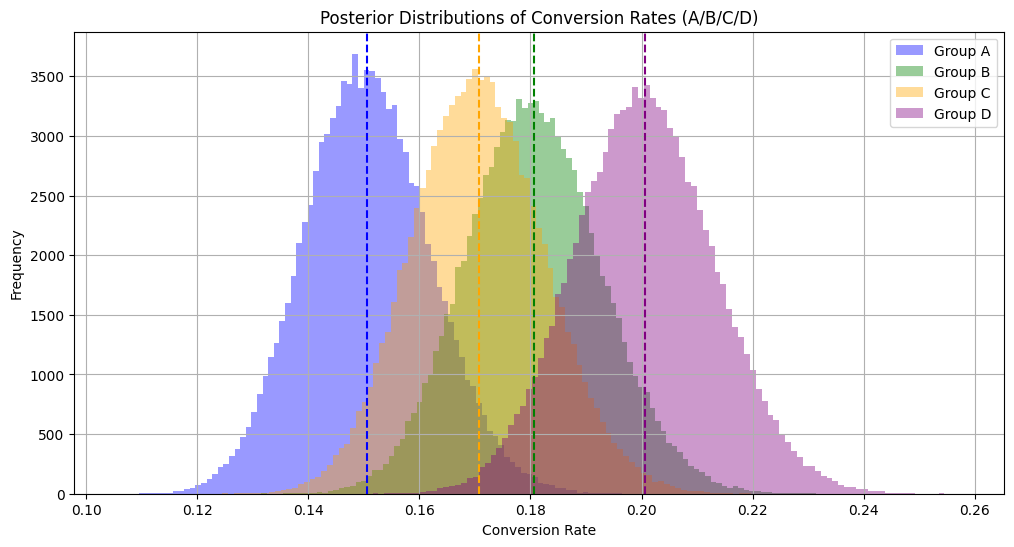

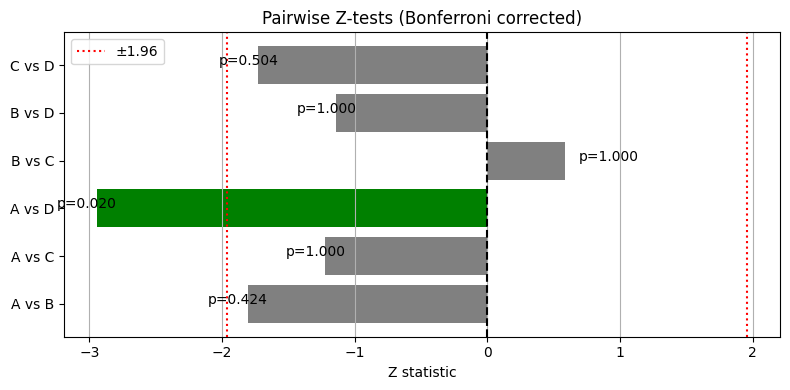

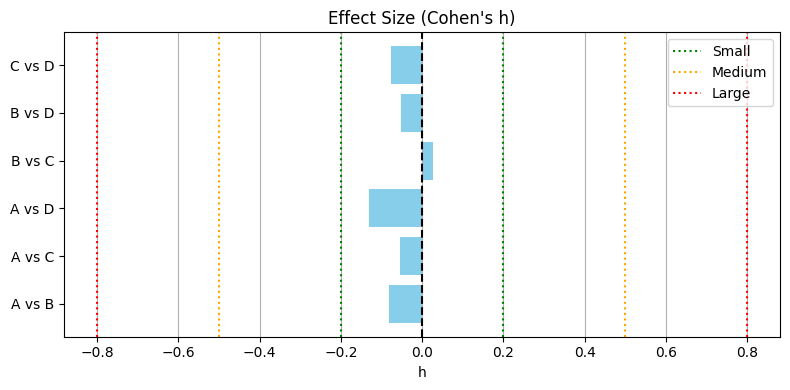

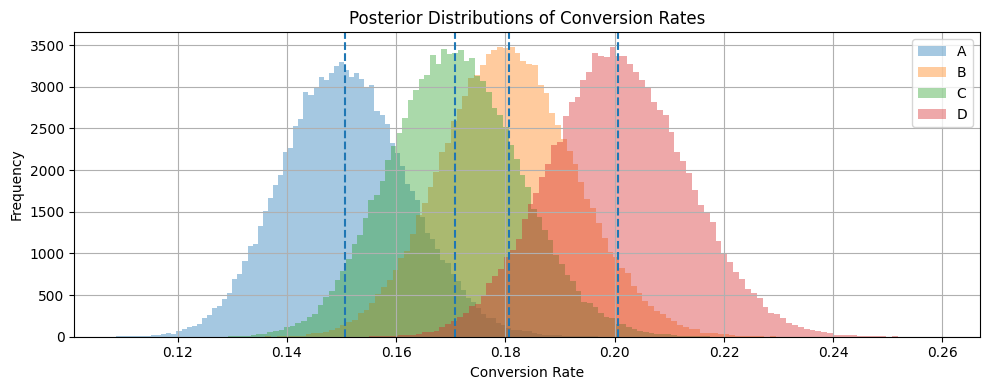

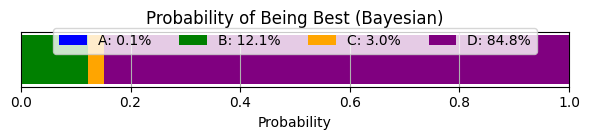

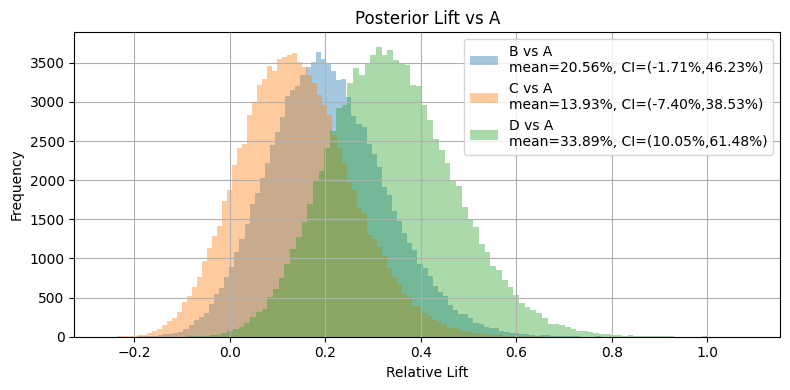

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from scipy.stats import beta, norm

# === 샘플 데이터 설정 (A/B/C/D 그룹) ===
group_names = ['A', 'B', 'C', 'D']
successes   = np.array([150, 180, 170, 200])
trials      = np.array([1000, 1000, 1000, 1000])
conversion_rates = successes / trials


# ✅ 베타 분포 파라미터 설정 (Beta(1,1) 사전 분포 사용)
alpha = [1 + s for s in successes]
beta_ = [1 + (n - s) for s, n in zip(successes, trials)]

# ✅ 샘플링
samples = 100_000
posterior_samples = {
    name: np.random.beta(a, b, samples)
    for name, a, b in zip(group_names, alpha, beta_)
}

# ✅ 평균 전환율 출력
print("✅ 그룹별 평균 전환율")
for name in group_names:
    mean_rate = np.mean(posterior_samples[name])
    print(f"{name}: {mean_rate:.3%}")

# ✅ 모든 쌍 간 비교: P(i > j)
print("\n✅ 그룹 간 전환율 우위 확률 (P(i > j))")
for i, j in itertools.combinations(group_names, 2):
    prob = np.mean(posterior_samples[i] > posterior_samples[j])
    print(f"P({i} > {j}) = {prob:.1%}")

# ✅ Posterior 분포 시각화
plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'orange', 'purple']
for name, color in zip(group_names, colors):
    plt.hist(posterior_samples[name], bins=100, alpha=0.4, label=f'Group {name}', color=color)
    plt.axvline(np.mean(posterior_samples[name]), color=color, linestyle='--')

plt.title("Posterior Distributions of Conversion Rates (A/B/C/D)")
plt.xlabel("Conversion Rate")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()



# === 1. 빈도주의: pairwise Z-test + Bonferroni 보정 ===
pairs   = [(i, j) for i in range(4) for j in range(i+1, 4)]
z_stats = []
p_vals  = []
labels  = []

for i, j in pairs:
    count = np.array([successes[i], successes[j]])
    nobs  = np.array([trials[i], trials[j]])
    z, p  = proportions_ztest(count, nobs)
    z_stats.append(z)
    p_vals.append(p)
    labels.append(f"{group_names[i]} vs {group_names[j]}")

reject, p_corr, _, _ = multipletests(p_vals, alpha=0.05, method='bonferroni')

plt.figure(figsize=(8, 4))
colors = ['green' if r else 'gray' for r in reject]
plt.barh(labels, z_stats, color=colors)
plt.axvline(0, color='black', linestyle='--')
plt.axvline(norm.ppf(0.975), color='red', linestyle=':', label='±1.96')
plt.axvline(-norm.ppf(0.975), color='red', linestyle=':')
for idx, (z, p) in enumerate(zip(z_stats, p_corr)):
    plt.text(z + 0.1 if z>0 else z - 0.3, idx, f"p={p:.3f}")
plt.title("Pairwise Z-tests (Bonferroni corrected)")
plt.xlabel("Z statistic")
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# === 2. 효과 크기: Cohen's h ===
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

effect_sizes = [cohens_h(conversion_rates[i], conversion_rates[j]) for i, j in pairs]

plt.figure(figsize=(8, 4))
plt.barh(labels, effect_sizes, color='skyblue')
plt.axvline(0, color='black', linestyle='--')
thresholds = [(0.2,'Small','green'), (0.5,'Medium','orange'), (0.8,'Large','red')]
for thr, name, col in thresholds:
    plt.axvline(thr, color=col, linestyle=':', label=name)
    plt.axvline(-thr, color=col, linestyle=':')
plt.title("Effect Size (Cohen's h)")
plt.xlabel("h")
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# === 3. 베이지안: posterior sampling & 분포 시각화 ===
alpha_params = 1 + successes
beta_params  = 1 + trials - successes
samples      = 100_000

post = {
    grp: np.random.beta(alpha_params[i], beta_params[i], samples)
    for i, grp in enumerate(group_names)
}

plt.figure(figsize=(10, 4))
for grp in group_names:
    plt.hist(post[grp], bins=100, alpha=0.4, label=grp)
    plt.axvline(post[grp].mean(), linestyle='--')
plt.title("Posterior Distributions of Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 4. 베이지안 의사결정 기준: Best 그룹 확률 ===
stacked = np.vstack([post[grp] for grp in group_names]).T
best_probs = [(stacked.argmax(axis=1) == i).mean() for i in range(len(group_names))]

plt.figure(figsize=(6, 1.5))
left = 0
colors = ['blue', 'green', 'orange', 'purple']
for prob, grp, col in zip(best_probs, group_names, colors):
    plt.barh(0, prob, left=left, color=col, label=f"{grp}: {prob:.1%}")
    left += prob
plt.title("Probability of Being Best (Bayesian)")
plt.xlim(0, 1)
plt.yticks([])
plt.xlabel("Probability")
plt.legend(ncol=4, bbox_to_anchor=(0.5, 1.2), loc='upper center')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# === 5. 베이지안 Lift 시각화 (vs A) ===
plt.figure(figsize=(8, 4))
for grp in group_names[1:]:
    lift = (post[grp] - post['A']) / post['A']
    mean_lift = lift.mean()
    ci_low, ci_high = np.percentile(lift, [2.5, 97.5])
    plt.hist(lift, bins=100, alpha=0.4,
             label=f"{grp} vs A\nmean={mean_lift:.2%}, CI=({ci_low:.2%},{ci_high:.2%})")
plt.title("Posterior Lift vs A")
plt.xlabel("Relative Lift")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



# 2

## 3


빈도주의적 접근 결과 (FDR 보정 후):


,Group Comparison,Z-Statistic,P-Value,Adjusted P-Value,Significance
0,A vs B,-1.807262,0.070721,0.168122,No
1,A vs C,-1.219875,0.222512,0.305156,No
2,A vs D,-2.942449,0.003256,0.019538,Yes
3,B vs C,0.588490,0.556204,0.556204,No
4,B vs D,-1.139976,0.254296,0.305156,No
5,C vs D,-1.727594,0.084061,0.168122,No


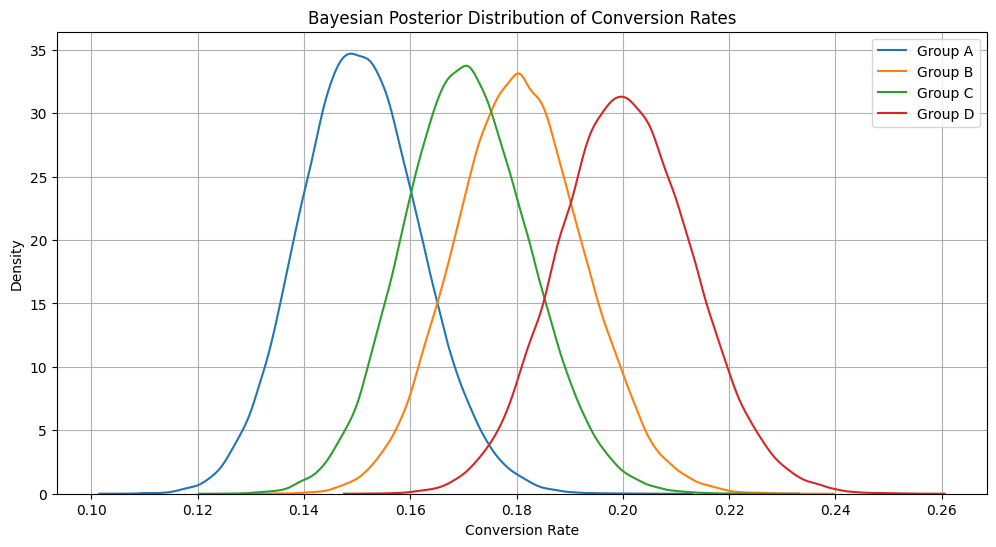


베이지안 접근 그룹 간 우위 확률:


,Group Comparison,P(Group1 > Group2)
0,A vs B,0.03566
1,A vs C,0.11166
2,A vs D,0.00175
3,B vs C,0.72092
4,B vs D,0.12797
5,C vs D,0.04229


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# 데이터 설정
group_names = ['A', 'B', 'C', 'D']
successes = np.array([150, 180, 170, 200])
trials = np.array([1000, 1000, 1000, 1000])

# 빈도주의 접근: proportions_ztest
pairwise_comparisons = [(i, j) for i in range(len(group_names)) for j in range(i+1, len(group_names))]
z_test_results = []

for (i, j) in pairwise_comparisons:
    stat, pval = proportions_ztest([successes[i], successes[j]], [trials[i], trials[j]])
    z_test_results.append((group_names[i], group_names[j], stat, pval))

# 다중 비교 보정 (FDR)
pvals = [res[3] for res in z_test_results]
rejects, adj_pvals, _, _ = multipletests(pvals, method='fdr_bh')

freq_results_df = pd.DataFrame({
    'Group Comparison': [f'{res[0]} vs {res[1]}' for res in z_test_results],
    'Z-Statistic': [res[2] for res in z_test_results],
    'P-Value': pvals,
    'Adjusted P-Value': adj_pvals,
    'Significance': ['Yes' if rej else 'No' for rej in rejects]
})

print("\n빈도주의적 접근 결과 (FDR 보정 후):")
display(freq_results_df)

# 베이지안 접근
alpha_prior, beta_prior = 1, 1  # 베타(1,1) 균일 사전분포 사용
samples = 100_000
posterior_samples = {
    name: beta.rvs(a=successes[i] + alpha_prior, b=trials[i] - successes[i] + beta_prior, size=samples)
    for i, name in enumerate(group_names)
}

# 베이지안 결과 시각화
plt.figure(figsize=(12, 6))
for name, samples in posterior_samples.items():
    sns.kdeplot(samples, label=f"Group {name}")

plt.title('Bayesian Posterior Distribution of Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# 베이지안 방식으로 그룹 간 우위 확률 계산
bayesian_probs = []
for (i, j) in pairwise_comparisons:
    prob = np.mean(posterior_samples[group_names[i]] > posterior_samples[group_names[j]])
    bayesian_probs.append({
        'Group Comparison': f'{group_names[i]} vs {group_names[j]}',
        'P(Group1 > Group2)': prob
    })

bayesian_results_df = pd.DataFrame(bayesian_probs)

print("\n베이지안 접근 그룹 간 우위 확률:")
display(bayesian_results_df)
